# Testing

### О чем этот ноутбук

Написанный мной код для определения необходимой ориентации существенно опирается на вывод аналитической формулы для угла, а также на знание того, что аппарат летает по круговой кеплеровой орбите. 

В предположении двжиения аппарата по круговой орбите с заданным наклонением $i$ и ДВУ $\Omega$ можно получить, что оптимальный угол поворота пластины относительно оси z орбитальной системы будет вычисляться из следующих условий (нулевой угол -- совпадение нормали к пластине с осью y орбитальной системы):

$ A = (-1) (\sin{u}\cos\Omega + \cos{u}|\cos{i}|\sin\Omega) = \langle \mathbf{x}, \mathbf{e}_x \rangle,$

$ B = |\sin{i}|\sin\Omega  = \langle \mathbf{x}, \mathbf{e}_y \rangle,$

$\phi_{opt} = argmax\{ |f(\phi_1)|, |f(\phi_2)| \}, \quad f(\phi) = -A\sin{\phi} + B\cos{\phi} = -\langle \mathbf{x}, \mathbf{e}_x \rangle\sin{\phi} + \langle \mathbf{x}, \mathbf{e}_y \rangle\cos{\phi},$

$\phi_{opt} = - \arctan(A/B)$

В этом ноутбуке происходит сравнение расчетов по аналитическим формулам с более простым в смысле кодинга расчетом через библиотеку poliastro (можно даже оценить насколько один код быстрее другого). С помощью библиотеки расчитываются коэффициенты А и В напрямую из положения и скорости КА на орбите, а также необходимые кватерниноны через матрицы поворота. Результаты сравниваются с собственным кодом.

In [52]:
import numpy as np
import matplotlib.pyplot as plt

from poliastro.twobody import Orbit
from poliastro.bodies import Earth
from astropy import units as u
from pyquaternion import Quaternion

In [4]:
# сделаем расчет коэффициентов А и В в формулах из первого пункта через модуль Orbit библиотеки poliastro
def get_ab_p(orbit):
    r = orbit.r
    v = orbit.v
    r_cross_v = np.linalg.cross(r, v)
    e_y = r_cross_v / np.linalg.norm(r_cross_v)
    e_x = v / np.linalg.norm(v)
    # так как все это уже задано в некоторой интерциальной системе (в случае с poliastro -- в GCRS), 
    # то считаем за x первый базисный вектор => первые компоненты векторов и дают искомое скалярное произведение
    return e_x[0], e_y[0]

# Здесь важно отметить, что такой расчет работает и для эллиптической орбиты 
# (так как при выводе соотноешний в пункте 1 мы существенно опирались на 
# свойство перпендикулярности скорость и радиус-вектора аппарата) 

# Окончательный расчет с помощью библиотеки
def get_phi_p(orbit):
    A, B = get_ab_p(orbit)
    phi1 = np.arctan2(-A , B)  # пластина исходной стороной вверх
    phi2 = np.arctan2(A , -B)  # пластина обратной стороной вверх
    return phi1 if orbit.raan.value < np.pi else np.pi + phi2

# Расчет орбитальной системы относительно инерциальной
# по положению и скорости аппарата
def get_orbital_frame_matrix(r, v):
    r_cross_v = np.linalg.cross(r, v)
    e_y = r_cross_v / np.linalg.norm(r_cross_v)
    e_x = v / np.linalg.norm(v)
    return np.array([e_x, e_y, np.linalg.cross(e_x, e_y)]).T

# Расчет собственной системы относительно инерциальной
# по положению орбитальной системы
def get_eigen_frame_matrix(e_x, e_y, e_z, phi):
    # собственаая система опирается существенно на орбитальную, так как ориентация аппарата жестко к ней привязана
    t_y = -e_x * np.sin(phi) + e_y * np.cos(phi)
    t_x = np.linalg.cross(t_y, e_z)
    return np.array([t_x, t_y, e_z]).T

# Расчет матрицы перехода из орбитальной системы в собственную систему аппарата
def get_orbital_2_eigen_matrix(r, v, phi):
    # сложим базисные вектора в матрицы переходов
    # эти матрицы задают преобразование поворота векторов из инерциального базиса 
    # в соотвествующий (то есть применяется активная точка зрения)
    orbital_matrix = get_orbital_frame_matrix(r, v)
    eigen_matrix = get_eigen_frame_matrix(orbital_matrix[:, 0], orbital_matrix[:, 1], orbital_matrix[:, 2], phi)
    # расчитаем матрицу перехода из одного базиса в другой
    # эта матрица перехода будет задавать поворот векторов из орбитального базиса в собственный 
    # но кажется, что это тривиальная задача
    transfrom_matrix = orbital_matrix.T @ eigen_matrix
    return transfrom_matrix

### 1. Сравнение расчета оптимального угла

In [94]:
# Зададим начальную орбиту аппарата
mu = 398600.4415                               
a = (6371 + 800) * u.km                                 
raan = 4 * np.pi / 5 * u.rad
ecc = 0 * u.one
argp = 0 * u.rad


# Расчет наклонения полярной орбиты в инерциальной системе координат
alpha = (90 - 23.44) / 180 * np.pi  # наклон Земной оси к плоскости эклиптики
theta = 3 * np.pi / 4   # угол между проекцией Земной оси на плоскость XY и направлением на Солнце (осью Х)
# наклонение орбиты в инерциальной системе
inc = (np.pi / 2 - np.abs(np.arctan(np.sin(theta - raan.value) / np.tan(alpha))))
inc = inc * u.rad

print("Наклонение: ", inc.value * 180 / np.pi)
print("ДВУ:", raan.value * 180 / np.pi)

Наклонение:  86.11985972558868
ДВУ: 144.0


In [95]:
# Расчет c помощью библиотечной реализации
nus = np.linspace(0, 2 * np.pi, 2000)
phi_opt_p = []
for nu in nus:
    orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu * u.rad)
    result = get_phi_p(orbit)
    phi_opt_p.append(result.value)

In [96]:
# Расчет с помощью написанной программы
from orientation_handler import SpacecraftOrientationHandler
from orbital_handler import OrbitalFrameOrientationHandler

spacefraft_orientation = SpacecraftOrientationHandler(a.value, inc.value, raan.value, mu)
orbital_frame_orientation = OrbitalFrameOrientationHandler(a.value, inc.value, raan.value)

# угол между нормалью к панели и направлением на Солнце
phis_my = spacefraft_orientation.optimal_phi(nus)
# освещенность панели на заданной ориентации
illuminance_my = spacefraft_orientation.illuminance(nus, phis_my)

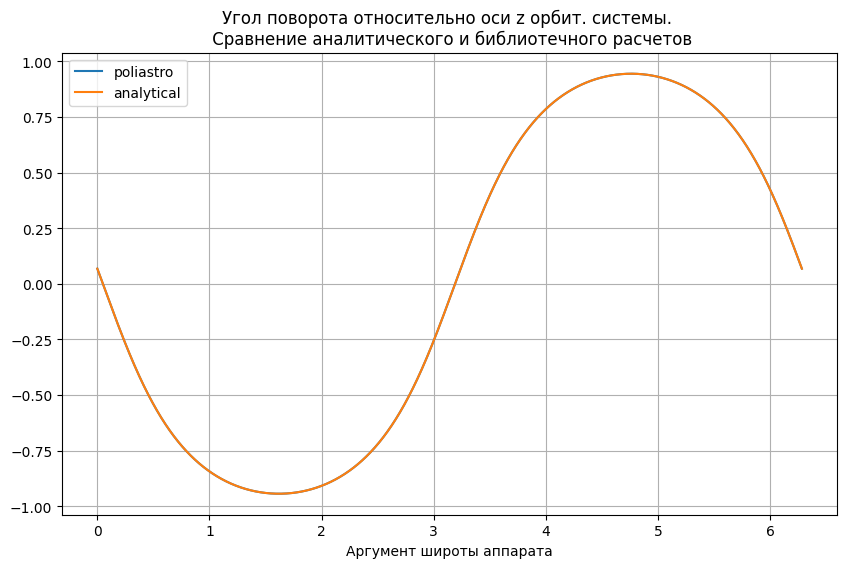

Интегральная ошибка в расчете оптимального угла:  1.309972121023127e-14


In [97]:
# сравниваем результаты
fig, ax = plt.subplots(ncols=1, figsize=(10, 6))
ax.plot(nus, phi_opt_p, label='poliastro')
ax.plot(nus, phis_my, label='analytical')
ax.grid()
ax.set_title("Угол поворота относительно оси z орбит. системы. \n Сравнение аналитического и библиотечного расчетов")
ax.set_xlabel("Аргумент широты аппарата")
ax.legend()
plt.show()

print("Интегральная ошибка в расчете оптимального угла: ", np.linalg.norm(np.array(phi_opt_p) - np.array(phis_my)))

### 2. Сравнение расчета кватернионов

In [98]:
def get_orbital_2_eigen_q(r, v, phi):
    return Quaternion(matrix=get_orbital_2_eigen_matrix(r, v, phi))

def get_orbital_frame_q(r, v):
    return Quaternion(matrix=get_orbital_frame_matrix(r, v))

def get_eigen_frame_q(e_x, e_y, e_z, phi):
    return Quaternion(matrix=get_eigen_frame_matrix(e_x, e_y, e_z, phi))


In [99]:
# Расчет с помощью poliastro
poli_q_o2sc_q = []
poli_q_i2sc_q = []

for nu,phi in zip(nus, phi_opt_p):
    orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu * u.rad)
    orbital_frame = get_orbital_frame_matrix(orbit.r, orbit.v)
    poli_q_o2sc_q.append(get_orbital_2_eigen_q(orbit.r, orbit.v, phi))
    poli_q_i2sc_q.append(get_eigen_frame_q(orbital_frame[:, 0], orbital_frame[:, 1], orbital_frame[:, 2], phi))


In [100]:
# Расчет с помощью написанной программы
from orientation_handler import SpacecraftOrientationHandler
from orbital_handler import OrbitalFrameOrientationHandler

spacefraft_orientation = SpacecraftOrientationHandler(a.value, inc.value, raan.value, mu)
orbital_frame_orientation = OrbitalFrameOrientationHandler(a.value, inc.value, raan.value)

 # ориентация относительно орбитатальных осей
q_o2sc_my_q = [spacefraft_orientation.orientation_in_orbital_frame(phi) for phi in phis_my]
 # ориентация относительно инерциальных осей
q_i2sc_my_q = [(orbital_frame_orientation.orbital_frame_orientation(u) * 
          spacefraft_orientation.orientation_in_orbital_frame(phi)) for (u, phi) in zip(nus, phis_my)]

In [101]:
# обработка кватернионов для сравнения 
# (где нужно -- домножение на -1, так как кватернионы q и -q описывают один и тот же поворот)

poli_q_o2sc_my = [quat.elements if np.abs(q_ref.w - quat.w) < 1e-10  else (-quat).elements \
                  for quat, q_ref in zip(poli_q_o2sc_q, q_o2sc_my_q)]
poli_q_i2sc_my = [quat.elements if np.abs(q_ref.w - quat.w) < 1e-10 else (-quat).elements \
                  for quat, q_ref in zip(poli_q_i2sc_q, q_i2sc_my_q)]

poli_q_o2sc_my = np.array(poli_q_o2sc_my)
poli_q_i2sc_my = np.array(poli_q_i2sc_my)

q_o2sc_my = [quat.elements  for quat in q_o2sc_my_q]
q_i2sc_my = [quat.elements  for quat in q_i2sc_my_q]

q_o2sc_my = np.array(q_o2sc_my)
q_i2sc_my = np.array(q_i2sc_my)

In [102]:
# Расчитаем разницу между полученными значениями как норму разницы матриц
print("Интегральная ошибка подсчета кватерниона из орбитальной в собственную: ", np.linalg.norm(poli_q_o2sc_my - q_o2sc_my))
print("Интегральная ошибка подсчета кватерниона из орбитальной в собственную: ",np.linalg.norm(poli_q_i2sc_my - q_i2sc_my))

Интегральная ошибка подсчета кватерниона из орбитальной в собственную:  8.319324792418969e-15
Интегральная ошибка подсчета кватерниона из орбитальной в собственную:  1.4264745287269635e-14


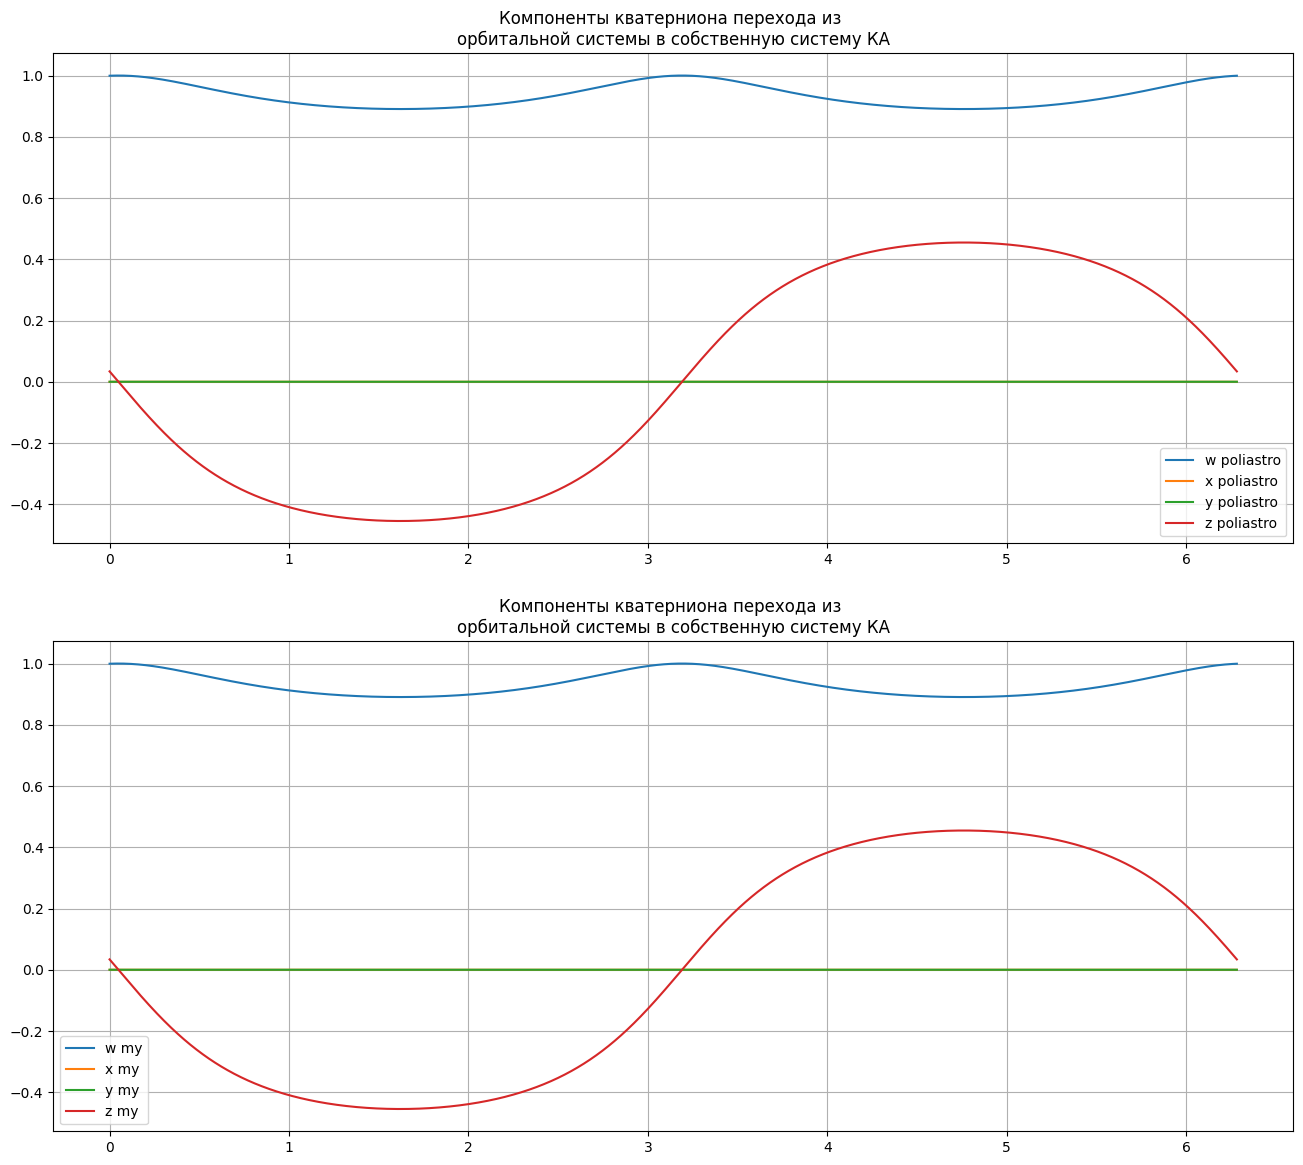

In [103]:
# Построим графики для визуального сравнения
fig, ax = plt.subplots(nrows=2, figsize=(16, 14))


ax[0].plot(nus, poli_q_o2sc_my, label=("w poliastro", "x poliastro", "y poliastro", "z poliastro"))
ax[1].plot(nus, q_o2sc_my, label=("w my", "x my", "y my", "z my"))
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_title("Компоненты кватерниона перехода из \nорбитальной системы в собственную систему КА")
ax[1].set_title("Компоненты кватерниона перехода из \nорбитальной системы в собственную систему КА")
plt.show()

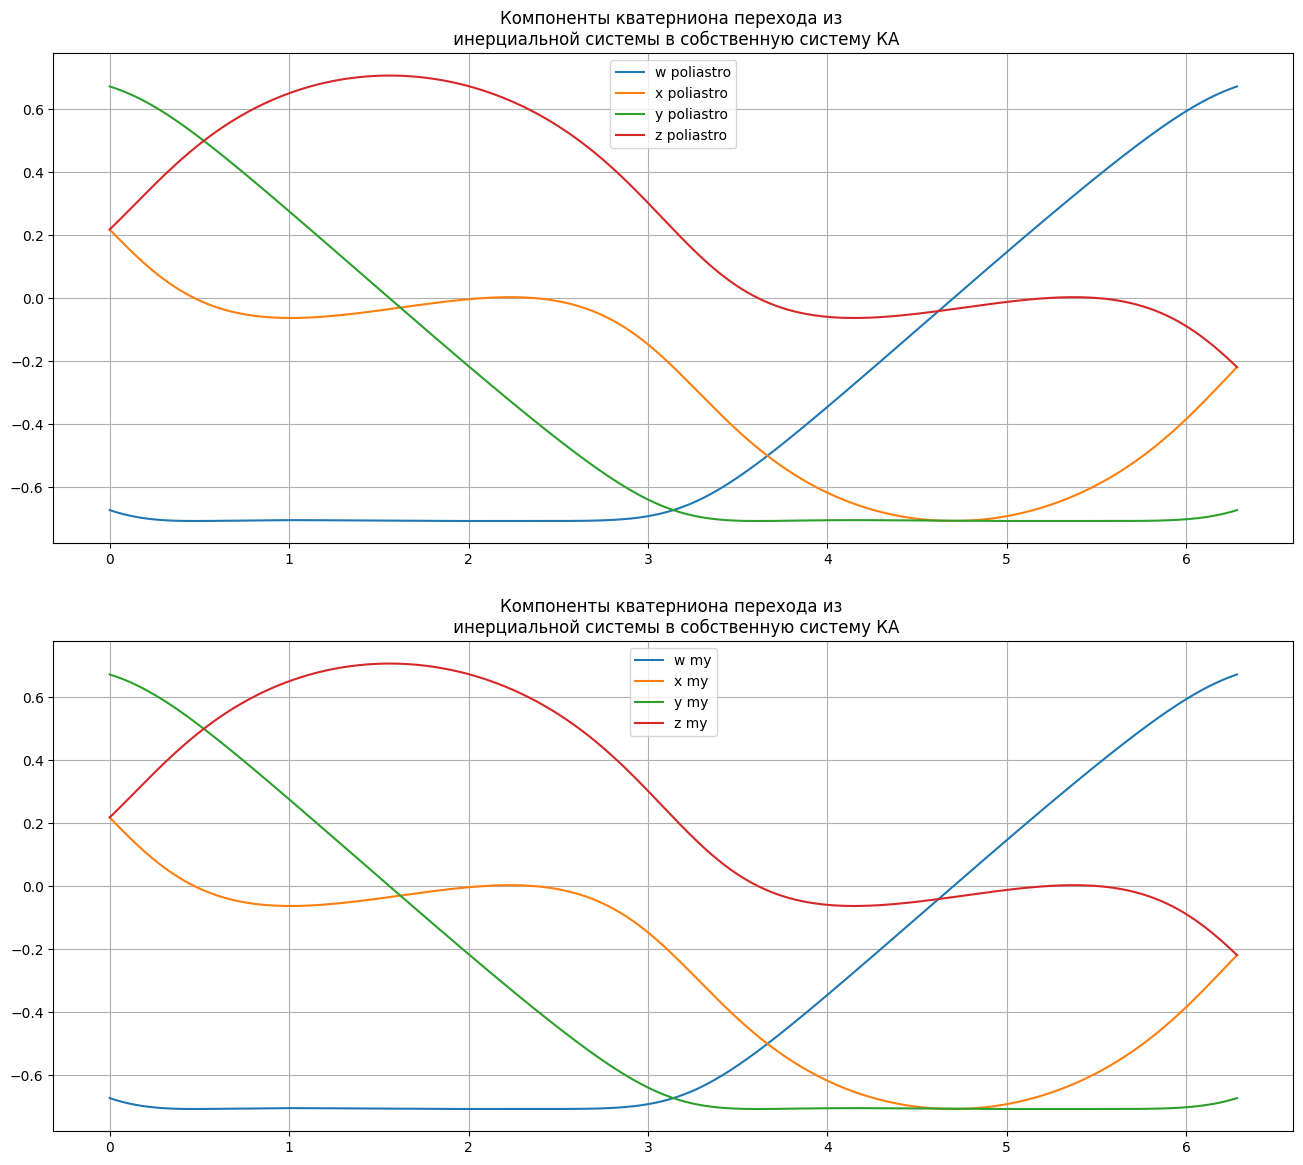

In [104]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 14))

ax[0].plot(nus, poli_q_i2sc_my, label=("w poliastro", "x poliastro", "y poliastro", "z poliastro"))
ax[1].plot(nus, q_i2sc_my, label=("w my", "x my", "y my", "z my"))

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_title("Компоненты кватерниона перехода из \n инерциальной системы в собственную систему КА")
ax[1].set_title("Компоненты кватерниона перехода из \n инерциальной системы в собственную систему КА")
plt.show()

### В заключение

Это код фактически дублирует функционал, необходимый для первых двух пунктов задачи, но реализован с помощью библиотеки poliastro. Такой подход позволяет посчитать ориентацию и для не круговой орбиты (а они обычно все такие), но работает дольше. Я использовал библиотечные реализации для отладки собственных классов и функций